<a href="https://colab.research.google.com/github/JangHanjun/Hanryang_Win_Formula/blob/main/PoongWinPercent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install konlpy

     |████████████████████████████████| 19.4 MB 3.3 MB/s 
     |████████████████████████████████| 448 kB 33.6 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 로드하기

In [34]:
chat_log = pd.read_csv('/content/chatlog.csv')

train_data = chat_log[:6000]
test_data = chat_log[6000:]

train_data.head()

,TEXT,LABEL
0,밟어,1
1,이게 말이돼,1
2,이거 저번에 했지않음,0
3,대혼돈의 풍토토다,1
4,풍월량 믿고 마리오 골랐다구,1


   LABEL  count
0      0   3485
1      1   2515


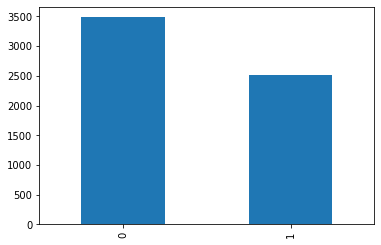

In [35]:
train_data['LABEL'].value_counts().plot(kind = 'bar')
print(train_data.groupby('LABEL').size().reset_index(name = 'count'))

토큰화 하기

In [36]:
okt = Okt()

In [37]:
X_train = []
for sentence in tqdm(train_data['TEXT']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    X_train.append(tokenized_sentence)

100%|██████████| 6000/6000 [00:02<00:00, 2940.71it/s]


In [38]:
X_test = []
for sentence in tqdm(test_data['TEXT']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    X_test.append(tokenized_sentence)

100%|██████████| 1224/1224 [00:00<00:00, 3015.20it/s]


정수 인코딩

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'번마': 1, '이': 2, '하다': 3, '오다': 4, '아': 5, '번': 6, '마리오': 7, '오': 8, '컷': 9, '우승': 10, '가다': 11, '가': 12, '형': 13, '다': 14, '야': 15, '어': 16, '맵': 17, '개': 18, '오늘': 19, '지다': 20, '에': 21, '실력': 22, '요': 23, '게': 24, '뭐': 25, '이다': 26, '배': 27, '못': 28, '걸': 29, '아니다': 30, '캇': 31, '먹다': 32, '느긋': 33, '네': 34, '보다': 35, '안': 36, '거': 37, '도': 38, '의': 39, '기출': 40, '탈락': 41, '핑키': 42, '좋다': 43, '진짜': 44, '나': 45, '오픈': 46, '루': 47, '풍': 48, '왜': 49, '잘': 50, '모태': 51, '너무': 52, '돼다': 53, '어어': 54, '은': 55, '고': 56, '오열': 57, '이기다': 58, '루이지': 59, '북': 60, '대기': 61, '개다': 62, '나이스': 63, '달달': 64, '없다': 65, '들': 66, '중': 67, '아깝다': 68, '낙마': 69, '있다': 70, '이네': 71, '힘내다': 72, '어르다': 73, '가즈': 74, '착하다': 75, '준비': 76, '풍선': 77, '핑크': 78, '오오': 79, '풍월': 80, '량': 81, '이야': 82, '마': 83, '믿다': 84, '날': 85, '이건': 86, '업보': 87, '지': 88, '모함': 89, '만': 90, '캬': 91, '싫다': 92, '적': 93, '헐다': 94, '자다': 95, '되다': 96, '는': 97, '을': 98, '기다리다': 99, '내': 100, '제발': 101, '포기': 102, '하': 103, '압도': 104

In [40]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 2323
등장 빈도가 1번 이하인 희귀 단어의 수: 1235
단어 집합에서 희귀 단어의 비율: 53.16401205337925
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.602075642543706


In [41]:
# 전체 단어 개수 중 빈도수 1이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1089


In [42]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

[[750], [2, 24, 117, 2, 53], [2, 37, 413, 21, 3, 202]]


In [43]:
y_train = np.array(train_data['LABEL'])
y_test = np.array(test_data['LABEL'])

In [44]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

5793
5793


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


패딩

In [45]:
print('댓글의 최대 길이 :',max(len(review) for review in X_train))
print('댓글의 평균 길이 :',sum(map(len, X_train))/len(X_train))

댓글의 최대 길이 : 60
댓글의 평균 길이 : 2.2651475919212842


In [46]:
max_len = 15
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### LSTM으로 분류

In [47]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
73/73 [==============================] - ETA: 0s - loss: 0.6201 - acc: 0.6601
Epoch 1: val_acc improved from -inf to 0.73167, saving model to best_model.h5
73/73 [==============================] - 7s 57ms/step - loss: 0.6201 - acc: 0.6601 - val_loss: 0.5125 - val_acc: 0.7317
Epoch 2/15
72/73 [============================>.] - ETA: 0s - loss: 0.4544 - acc: 0.8008
Epoch 2: val_acc improved from 0.73167 to 0.79638, saving model to best_model.h5
73/73 [==============================] - 3s 45ms/step - loss: 0.4544 - acc: 0.8004 - val_loss: 0.4618 - val_acc: 0.7964
Epoch 3/15
73/73 [==============================] - ETA: 0s - loss: 0.3856 - acc: 0.8267
Epoch 3: val_acc improved from 0.79638 to 0.81018, saving model to best_model.h5
73/73 [==============================] - 4s 49ms/step - loss: 0.3856 - acc: 0.8267 - val_loss: 0.4420 - val_acc: 0.8102
Epoch 4/15
73/73 [==============================] - ETA: 0s - loss: 0.3634 - acc: 0.8345
Epoch 4: val_acc improved from 0.81018 to 0.

In [48]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

39/39 [==============================] - 1s 8ms/step - loss: 0.4302 - acc: 0.7958

 테스트 정확도: 0.7958


In [49]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 풍월량 우승!!\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 이번마 낙마!!\n".format((1 - score) * 100))

In [60]:
sentiment_predict('루')

92.90% 확률로 이번마 낙마!!

